# Electricity Demand Forecasting

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




### <a id='import'> 1. Import Modules</a>

In [1]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

In [2]:
warnings.filterwarnings('ignore')

### 2. Data Import <a id='read_data'></a>

In [3]:
data_file = '../data/big_demand_temp_train_by_week.csv'

In [4]:
full_df = pd.read_csv(data_file, index_col=0)
full_df.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,5731095.0,13845790.0,82.21,73.78,79.45,70.22,93.37,95.83,0.0
2015-07-13,6067423.0,13845790.0,89.36,84.02,90.26,83.36,98.36,99.60,0.0
2015-07-20,6233738.0,13845790.0,87.65,80.50,88.28,78.39,98.36,98.03,0.0
2015-07-27,6473305.0,13845790.0,86.55,78.30,95.77,82.20,106.58,106.40,0.0
2015-08-03,6166221.0,13845790.0,91.70,81.52,83.53,70.89,95.65,95.56,0.0


#### 2.A Clean the data frame <a id='clean_data'></a>

In [5]:
# Convert the time string to a datetime object
full_df.index = pd.DatetimeIndex(full_df.index)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2015-07-06 to 2017-10-30
Data columns (total 9 columns):
week_demand    122 non-null float64
CA_pop         122 non-null float64
la_high        122 non-null float64
sd_high        122 non-null float64
sj_high        122 non-null float64
sf_high        122 non-null float64
sac_high       122 non-null float64
f_high         122 non-null float64
DOW            122 non-null float64
dtypes: float64(9)
memory usage: 9.5 KB


In [6]:
full_df.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,5731095.0,13845790.0,82.21,73.78,79.45,70.22,93.37,95.83,0.0
2015-07-13,6067423.0,13845790.0,89.36,84.02,90.26,83.36,98.36,99.60,0.0
2015-07-20,6233738.0,13845790.0,87.65,80.50,88.28,78.39,98.36,98.03,0.0
2015-07-27,6473305.0,13845790.0,86.55,78.30,95.77,82.20,106.58,106.40,0.0
2015-08-03,6166221.0,13845790.0,91.70,81.52,83.53,70.89,95.65,95.56,0.0


#### 2.B Extending Exogenous Regressors To Include Day Of Week <a id='extend_dow'></a>

In [7]:
new_df = full_df.drop('DOW', axis=1)

new_df.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high
2015-07-06,5731095.0,13845790.0,82.21,73.78,79.45,70.22,93.37,95.83
2015-07-13,6067423.0,13845790.0,89.36,84.02,90.26,83.36,98.36,99.60
2015-07-20,6233738.0,13845790.0,87.65,80.50,88.28,78.39,98.36,98.03
2015-07-27,6473305.0,13845790.0,86.55,78.30,95.77,82.20,106.58,106.40
2015-08-03,6166221.0,13845790.0,91.70,81.52,83.53,70.89,95.65,95.56


#### 2.C Data Split <a id='data_split'></a>

In [8]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [9]:
# Split the data frame into two parts
train_len = int(0.6 * data_len)
window_len = int(0.13 * data_len)

In [10]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]
X_walk2 = new_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = new_df.iloc[train_len+2*window_len:, :]

In [11]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2015-07-06 to 2016-11-21
Data columns (total 8 columns):
week_demand    73 non-null float64
CA_pop         73 non-null float64
la_high        73 non-null float64
sd_high        73 non-null float64
sj_high        73 non-null float64
sf_high        73 non-null float64
sac_high       73 non-null float64
f_high         73 non-null float64
dtypes: float64(8)
memory usage: 5.1 KB


In [12]:
# Add Log_demand to the dataframe
X_train['log_demand'] = np.log(X_train['week_demand'])
X_walk1['log_demand'] = np.log(X_walk1['week_demand'])
X_walk2['log_demand'] = np.log(X_walk2['week_demand'])
X_walk3['log_demand'] = np.log(X_walk3['week_demand'])

In [13]:
X_train.tail()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2016-10-24,4998192.0,13911737.0,81.35,80.34,79.15,68.47,78.09,83.80,15.424587
2016-10-31,4923159.0,13911737.0,86.26,77.12,74.70,70.78,73.61,76.89,15.409461
2016-11-07,5131645.0,13911737.0,93.09,93.61,78.05,73.52,76.26,83.08,15.450937
2016-11-14,4897298.0,13911737.0,87.53,83.86,70.18,64.58,73.51,76.66,15.404194
2016-11-21,4737510.0,13911737.0,79.03,76.49,63.73,59.76,61.00,61.10,15.371022


In [14]:
X_walk1.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2016-11-28,5025013.0,13911737.0,71.95,72.32,64.80,61.63,58.25,59.55,15.429939
2016-12-05,5116373.0,13911737.0,65.87,65.85,65.39,61.34,61.30,67.17,15.447956
2016-12-12,5088765.0,13911737.0,70.58,70.06,62.86,60.46,62.56,67.36,15.442546
2016-12-19,5136727.0,13911737.0,76.94,77.12,64.32,61.26,59.27,56.19,15.451927
2016-12-26,4936362.0,13996299.0,80.49,82.23,62.01,59.05,57.06,59.39,15.412139


In [15]:
X_walk1.tail()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2017-02-06,5039201.0,13996299.0,74.72,71.51,66.13,63.78,63.50,68.60,15.432758
2017-02-13,4861589.0,13996299.0,78.26,71.63,71.49,65.67,65.40,72.37,15.396876
2017-02-20,4845825.0,13996299.0,65.85,71.11,59.96,58.74,59.33,67.54,15.393628
2017-02-27,4802011.0,13996299.0,79.84,75.92,67.46,64.25,66.12,69.64,15.384545
2017-03-06,4789963.0,13996299.0,85.88,77.26,76.83,69.64,76.52,75.47,15.382033


In [17]:
X_walk2.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2017-03-13,4883098.0,13996299.0,87.63,82.75,82.00,76.10,79.31,86.14,15.401290
2017-03-20,4760186.0,13996299.0,69.31,68.61,68.26,63.19,69.51,75.17,15.375797
2017-03-27,4642255.0,13996299.0,81.57,76.89,78.77,73.80,79.32,78.54,15.350711
2017-04-03,4749068.0,13996299.0,82.82,74.70,77.68,70.63,80.49,82.38,15.373459
2017-04-10,4707345.0,13996299.0,76.13,71.62,70.49,65.22,68.69,77.65,15.364635


### 3. Helper Functions <a id='helper'></a>

In [18]:
# This funtion tests the stationarity of the data set
#   The function was originally published as part of the Blog post
#
#   https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
#
#
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [19]:
from collections import defaultdict
def order_sweep(model, arima_order_list, seasonal_order_list, endo_data, exo_data=None) :
    aic_dict = defaultdict(dict)
    i=0
    for order in arima_order_list :
        for seasonal in seasonal_order_list :
            if exo_data is not None :
                mod = model(endo_data, order=order, seasonal_order=seasonal, exog=exo_data)
            else :
                mod = model(endo_data, order=order, seasonal_order=seasonal)
                
            try :
                res = mod.fit()
                aic_dict[i] = {'order': order, 'seasonal order': seasonal, 
                    'aic': res.aic, 'bic':res.bic, 'mse': res.mse}
            except :
                continue
                
            i += 1
    return aic_dict

In [20]:
def top_results(result_dict, test_key, count) :
    top_result = [1000000]*count
    order_list = [0]*count
    ret_results = []
    for i in result_dict.keys() :
        if result_dict[i][test_key] < max(top_result) :
            top_result[top_result.index(max(top_result))] = result_dict[i][test_key]
            order_list[top_result.index(max(top_result))] = i
            
    for idx in order_list :
        ret_results.append(result_dict[idx])
        
    return sorted(ret_results, key=lambda x : x[test_key])
        

### 4. Data Analysis <a id='analysis'></a>

#### 4.1 Stationarity Testing <a id='stationarity'></a>

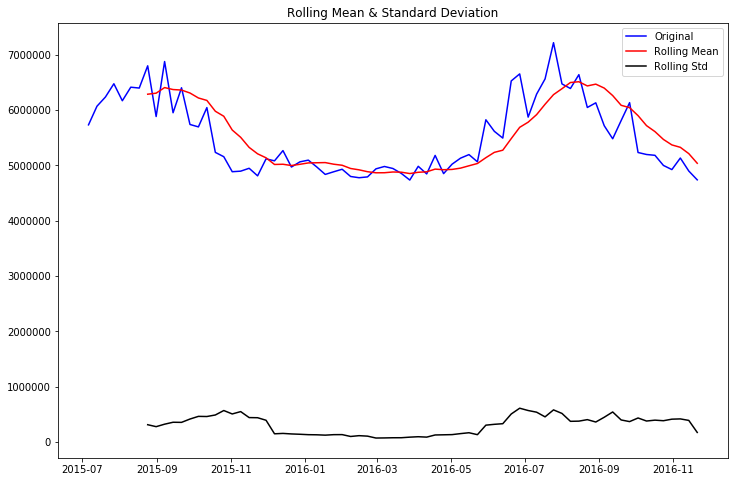

Results of Dickey-Fuller Test:
p-value = 0.6122. The series is likely non-stationary.
Test Statistic                 -1.336724
p-value                         0.612208
#Lags Used                      2.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [21]:
test_stationarity(X_train.week_demand, window=8)

Daily data is not stationary.  Try a simple difference to see if we can get a stationary result

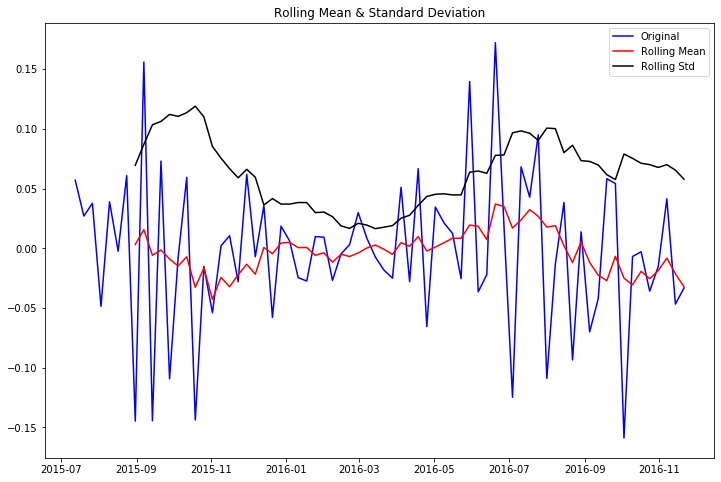

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.899242e+00
p-value                        4.228663e-12
#Lags Used                     1.000000e+00
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [22]:
diff_demand_day = X_train.week_demand.diff()[1:]
log_demand = np.log(X_train.week_demand)

test_stationarity(log_demand.diff()[1:], window=8)

Need to take the log of the daily demand to get a stationary time series

#### 4.2 Autocorrelation <a id='autocorr'></a>

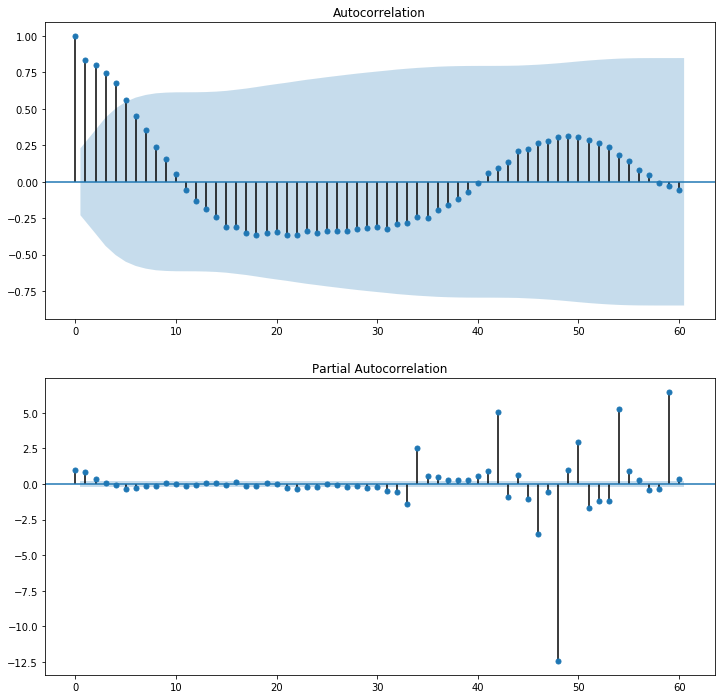

In [23]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_demand, lags=60, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_demand, lags=60, ax=ax2)# , lags=40

### 5. Modeling <a id='modeling'></a>

#### 5.1 SARIMAX Without Exogeneous Data <a id='SARI_NoX'></a>

In [58]:
# Define the model for SARIMAX just using the demand data
order_list =[(1,0,0),
             (2,0,0),
             (3,0,0),
             (4,0,0),
             (1,0,1),
             (2,0,1),
             (3,0,1),
             (4,0,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(0,0,0, 52),
                (1,0,0, 52),
                (2,0,0, 52)]

result_dict1 = order_sweep(SARIMAX, order_list, seasonal_list,  endo_data=X_train['log_demand'])

#res1 = seasonal_model1.fit()

In [24]:
for result in top_results(result_dict1, 'aic', 5) :
    print(result)


{'order': (4, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -292.71326240706895, 'bic': -276.62047504432365, 'mse': 2.245301724600878}
{'order': (2, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -280.8348044136432, 'bic': -270.10627950514635, 'mse': 2.245812202625783}
{'order': (1, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -280.4772232778556, 'bic': -269.74869836935875, 'mse': 2.24586127957706}
{'order': (4, 0, 0), 'seasonal order': (0, 0, 0, 52), 'aic': -262.655800577149, 'bic': -249.2451444415279, 'mse': 2.2462333044144307}
{'order': (2, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -255.37288070922756, 'bic': -241.96222457360645, 'mse': 2.2465415187118523}


In [25]:
for result in top_results(result_dict1, 'bic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (3, 0, 0), 'seasonal order': (0, 0, 0, 52), 'aic': -297.71980970516194, 'bic': -286.99128479666507, 'mse': 2.2452822895753486}
{'order': (3, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -293.9769282310924, 'bic': -280.56627209547133, 'mse': 2.245332069149443}
{'order': (2, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -280.8348044136432, 'bic': -270.10627950514635, 'mse': 2.245812202625783}
{'order': (1, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -280.4772232778556, 'bic': -269.74869836935875, 'mse': 2.24586127957706}
{'order': (2, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -255.37288070922756, 'bic': -241.96222457360645, 'mse': 2.2465415187118523}


In [26]:
for result in top_results(result_dict1, 'mse', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (4, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -286.3480388529605, 'bic': -264.89098903596675, 'mse': 2.245229486567956}
{'order': (3, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -289.73320232079743, 'bic': -270.95828373092786, 'mse': 2.2452891601460028}
{'order': (4, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -292.71326240706895, 'bic': -276.62047504432365, 'mse': 2.245301724600878}
{'order': (3, 0, 1), 'seasonal order': (0, 0, 0, 52), 'aic': -293.9769282310924, 'bic': -280.56627209547133, 'mse': 2.245332069149443}
{'order': (2, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -255.37288070922756, 'bic': -241.96222457360645, 'mse': 2.2465415187118523}


In [59]:
# Now choose the results that seem to work the best above and fit the model
best_order1 = (2, 0, 1)
best_seasonal_order1 = (1, 0, 0, 52)
model1 = SARIMAX(log_demand, order=best_order1, seasonal_order=best_seasonal_order1)
res1 = model1.fit()

In [60]:
print(res1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         week_demand   No. Observations:                  109
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 52)   Log Likelihood                 -33.812
Date:                             Sat, 21 Mar 2020   AIC                             77.624
Time:                                     22:02:38   BIC                             91.081
Sample:                                 07-06-2015   HQIC                            83.081
                                      - 07-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1597      0.070      2.270      0.023       0.022       0.298
ar.L2          0.7804      

In [61]:
res1.aic, res1.bic, res1.mse

(77.62399800949467, 91.08073742064039, 2.271549289346549)

In [62]:
# Save the trained model
filename = 'SARIMAX_wo_exog_week.sav'
pickle.dump(model1, open(filename, 'wb'))

In [28]:
demand_hat = np.exp(res1.fittedvalues)

##### 5.1.1 SARIMAX Without Exogeneous Data - Fit Plot Close <a id='plot-SARI_fit_zoom'></a>

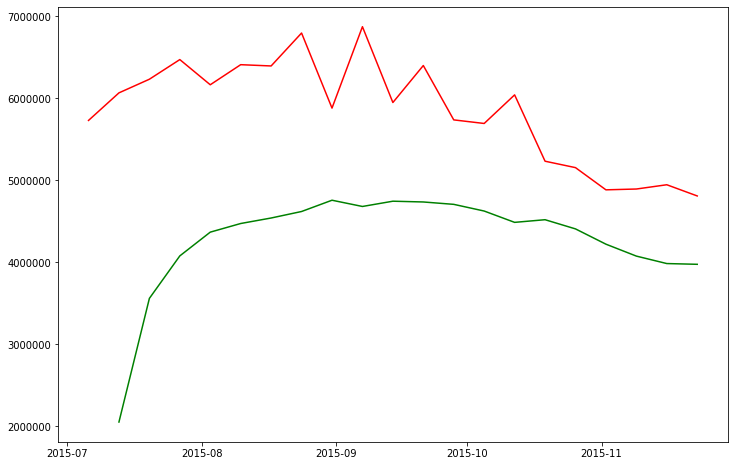

In [29]:
fig = plt.figure(figsize=[12, 8])
close_window = 3*7

plt.plot(demand_hat[1:close_window], label='Predicted', c='g')
plt.plot(X_train.index[:close_window], X_train['week_demand'].values[:close_window], c='r',\
    label='Actual (train)')

##### 5.1.2 SARIMAX Without Exogeneous Data - Fit Plot 3 Months  <a id='plot-SARI_fit_wide'></a>

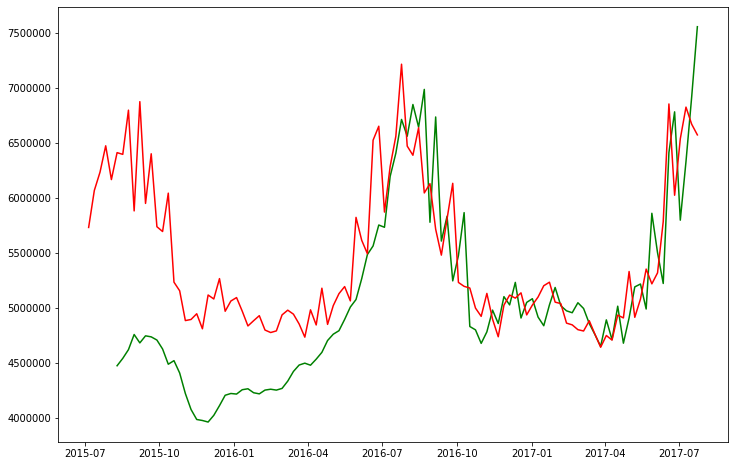

In [30]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat[5:1000], c='g')
plt.plot(X_train.index[0:1000], X_train['week_demand'].values[0:1000], c='r')

----
----

##### 5.1.3 SARIMAX Without Exogeneous Data - Forecast <a id='forecast-SARI_nox'></a>

----

In [63]:
predict_steps = 7*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

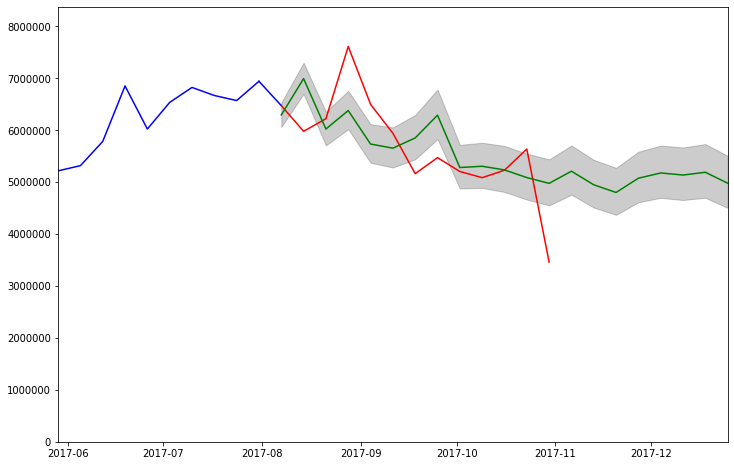

In [64]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times1))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['week_demand']), max(X_walk1['week_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['week_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['week_demand'].index[0]], \
          [X_train['week_demand'].values[-1], X_walk1['week_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['week_demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

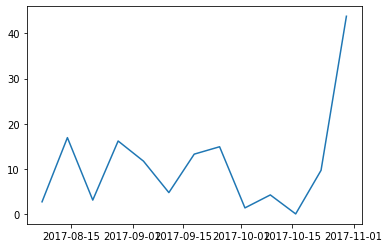

In [65]:
samp_len = min([len(X_walk1), len(pred_vals1)])
residuals = [abs(X_walk1['week_demand'].values[x] - pred_vals1.values[x]) / \
        X_walk1['week_demand'].values[x] * 100 for x in range(samp_len)]

plt.plot(pred_times1[:samp_len], residuals)
#plt.ylim(0, 7000)

In [66]:
mape1 = np.mean(residuals[3])
print(mape1)

16.216550980053075


#### 5.2 SARIMAX With Exogeneous Data <a id='model-SARIMAX-wexog'></a>

In [67]:
# The trailing columns are city temperatures and state population
important_cities = ['la_high',  'f_high']

In [2]:
# Define the model for SARIMAX just using the demand data
order_list =[(1,0,1),
             (2,0,1),
             (2,0,0),
             (3,0,0),
             (3,0,1),
             (4,0,0)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(1,0,0, 52),
                (2,0,0, 52)]

result_dict2 = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[important_cities])

#res1 = seasonal_model1.fit()

NameError: name 'order_sweep' is not defined

In [39]:
for result in top_results(result_dict2, 'aic', 5) :
    print(result)


{'order': (3, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -299.50666956414125, 'bic': -275.36748852002324, 'mse': 2.100295737854242}
{'order': (3, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -292.1433171202502, 'bic': -270.6862673032564, 'mse': 2.106415922316074}
{'order': (2, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -290.0558725538652, 'bic': -273.9630851911199, 'mse': 2.111345229695238}
{'order': (3, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -264.48106943534884, 'bic': -243.02401961835508, 'mse': 2.0689216634070626}
{'order': (2, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -237.1316021271197, 'bic': -215.67455231012593, 'mse': 2.1055251645257327}


In [40]:
for result in top_results(result_dict2, 'bic', 5) :
    print(result)


{'order': (3, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -299.50666956414125, 'bic': -275.36748852002324, 'mse': 2.100295737854242}
{'order': (2, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -290.0558725538652, 'bic': -273.9630851911199, 'mse': 2.111345229695238}
{'order': (3, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -292.1433171202502, 'bic': -270.6862673032564, 'mse': 2.106415922316074}
{'order': (3, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -264.48106943534884, 'bic': -243.02401961835508, 'mse': 2.0689216634070626}
{'order': (2, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -237.1316021271197, 'bic': -215.67455231012593, 'mse': 2.1055251645257327}


In [41]:
for result in top_results(result_dict2, 'mse', 5) :
    print(result)


{'order': (4, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': 205.6378240237253, 'bic': 229.77700506784328, 'mse': 1.2911462504054687}
{'order': (1, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -113.15342807447482, 'bic': -97.06064071172949, 'mse': 1.8836225500702701}
{'order': (3, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -264.48106943534884, 'bic': -243.02401961835508, 'mse': 2.0689216634070626}
{'order': (1, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -219.39393751975012, 'bic': -200.61901892988058, 'mse': 2.0960617067622174}
{'order': (3, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -252.98658939407318, 'bic': -234.21167080420364, 'mse': 2.1054345543308095}


In [1]:
# Now choose the results that seem to work the best above and fit the model
best_order2 = (3, 0, 1)
best_seasonal_order2 = (1, 0, 0, 52)
model2 = SARIMAX(X_train['log_demand'], order=best_order2, seasonal_order=best_seasonal_order2, \
            exog=X_train[important_cities])
res2 = model2.fit()

NameError: name 'SARIMAX' is not defined

In [69]:
print(res2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          log_demand   No. Observations:                  109
Model:             SARIMAX(3, 0, 1)x(1, 0, [], 52)   Log Likelihood                 155.365
Date:                             Sat, 21 Mar 2020   AIC                           -294.731
Time:                                     22:03:40   BIC                           -273.200
Sample:                                 07-06-2015   HQIC                          -285.999
                                      - 07-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
la_high        0.0015      0.001      2.514      0.012       0.000       0.003
f_high         0.0038      

In [70]:
# Save the trained model
filename = 'SARIMAX_w_exog_week.sav'
pickle.dump(model2, open(filename, 'wb'))

In [71]:
res2.aic

-294.73085862219637

In [72]:
demand_hat2 = np.exp(res2.fittedvalues)

##### 5.2.1 SARIMAX With Exogeneous Data - Fit Plot Close <a id='plot-SARI_exog_fit_zoom'></a>

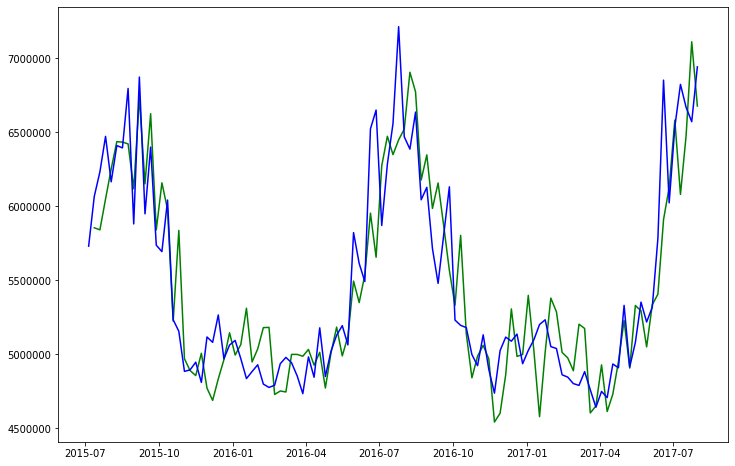

In [73]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat2[1:], c='g')
plt.plot(X_train.index, X_train['week_demand'].values, c='b')

----
----

##### 5.2.2 SARIMAX With Exogeneous Data - Fit Plot 3 Month <a id='plot-SARI_exof_fit_wide'></a>

----

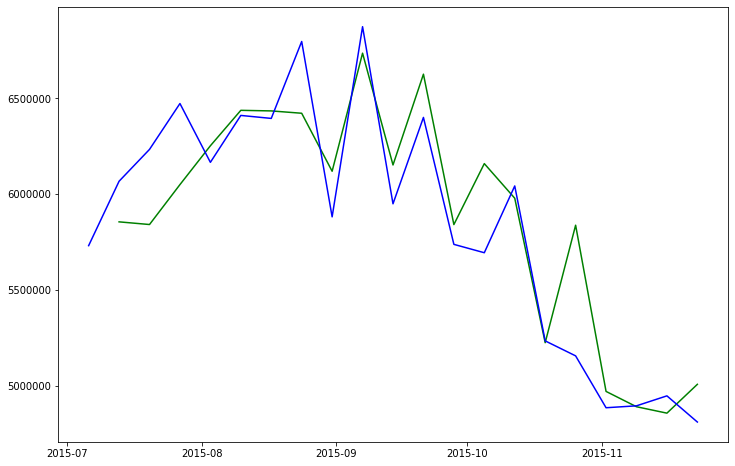

In [74]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat2[1:21], label='Prediction', c='g')
actual = X_train['week_demand'].values
plt.plot(X_train.index[:21], X_train['week_demand'].values[:21], label='Actual', c='b')

----
----
##### 5.2.3 SARIMAX With Exogeneous Data - Forecast  <a id='forecast-SARI_exog'></a>
----

In [75]:
predict_steps = 13
predict2 = res2.get_forecast(predict_steps, 
                exog=X_walk1[important_cities].values[:predict_steps, :])
pred_ci2 = np.exp(predict2.conf_int(alpha=0.5))
pred_vals2 = np.exp(predict2.predicted_mean)

In [76]:
aic2 = res2.aic

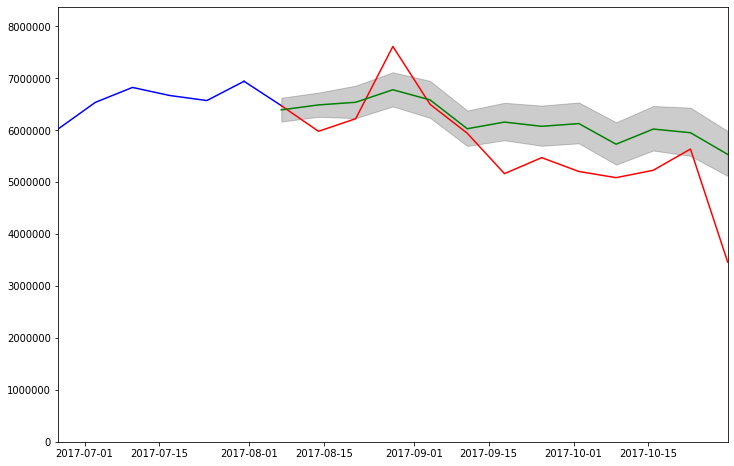

In [77]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci2.iloc[:, 0].values
high_values = pred_ci2.iloc[:, 1].values
pred_times2 = pred_ci2.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times2))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['week_demand']), max(X_walk1['week_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['week_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['week_demand'].index[0]], \
          [X_train['week_demand'].values[-1], X_walk1['week_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['week_demand'].values, c='r')
plt.plot(pred_times2, pred_vals2.values, c='g')


plt.fill_between(pred_times2, low_values, high_values, color='k', alpha=0.2)

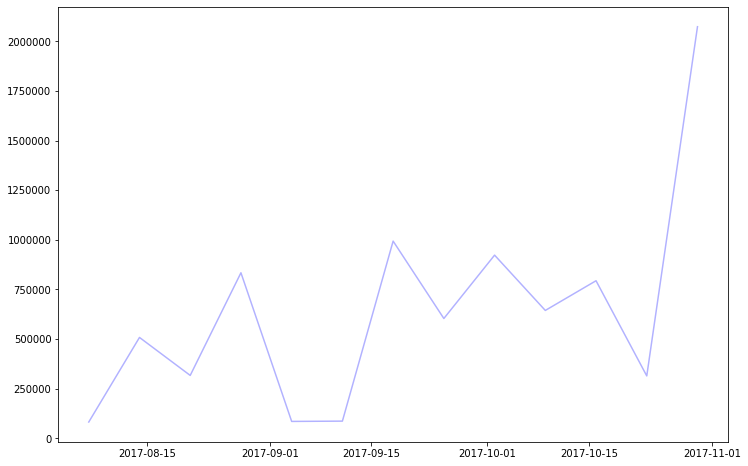

In [78]:
fig = plt.figure(figsize=[12, 8])
residuals2 = [abs(X_walk1['week_demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
plt.plot(pred_times2, residuals2, c='b', alpha=0.3)
#plt.ylim(0, 10000)

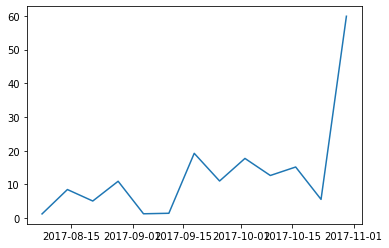

In [80]:
samp_len = min([len(X_walk1), len(pred_vals2)])
residuals2 = [abs(X_walk1['week_demand'].values[x] - pred_vals2.values[x])/ \
             X_walk1['week_demand'].values[x]*100 for x in range(samp_len)]
plt.plot(pred_times2[:samp_len], residuals2)


In [81]:
mape2 = np.mean(residuals2[:3])
print(mape2)

4.953236107135463


----
----
#### 5.3 SARIMAX With Extended Exogeneous Data <a id='model-SARI-xexog'></a>
----

In [24]:
# Use all the dummies for the day of the week but don't use the DOW column
all_exog_columns = X_train.columns[1:-1]
all_exog_columns = ['CA_pop', 'la_high', 'f_high']

In [57]:
# Define the model for SARIMAX just using the demand data
order_list =[(1,0,1),
             (2,0,1),
             (2,0,0),
             (3,0,0),
             (3,0,1),
             (4,0,0)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(1,0,0, 52),
                (2,0,0, 52)]

result_dict3 = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[all_exog_columns])


In [58]:
for result in top_results(result_dict3, 'aic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (2, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -314.5730103181489, 'bic': -290.4338292740309, 'mse': 0.0027072096567791752}
{'order': (4, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -311.5360377047056, 'bic': -282.0325942063392, 'mse': 0.0026814867218734255}
{'order': (1, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -311.432027695696, 'bic': -289.97497787870225, 'mse': 0.002770895398833051}
{'order': (2, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -310.1476051628881, 'bic': -288.6905553458944, 'mse': 0.002800462693030807}
{'order': (2, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -309.40133437661376, 'bic': -285.2621533324958, 'mse': 0.002771309324430401}


In [59]:
for result in top_results(result_dict3, 'bic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (1, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -311.432027695696, 'bic': -289.97497787870225, 'mse': 0.002770895398833051}
{'order': (1, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -311.432027695696, 'bic': -289.97497787870225, 'mse': 0.002770895398833051}
{'order': (2, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -310.1476051628881, 'bic': -288.6905553458944, 'mse': 0.002800462693030807}
{'order': (3, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -313.4955530959731, 'bic': -286.6742408247309, 'mse': 0.0026849942293996985}
{'order': (2, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -313.23052661530653, 'bic': -286.4092143440643, 'mse': 0.00269124398507006}


In [60]:
for result in top_results(result_dict3, 'mse', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (4, 0, 0), 'seasonal order': (2, 0, 0, 52), 'aic': -311.5360377047056, 'bic': -282.0325942063392, 'mse': 0.0026814867218734255}
{'order': (3, 0, 1), 'seasonal order': (2, 0, 0, 52), 'aic': -311.51405544346756, 'bic': -282.0106119451011, 'mse': 0.002682921206620225}
{'order': (3, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -307.45763624456754, 'bic': -280.6363239733253, 'mse': 0.0027658857238337534}
{'order': (3, 0, 0), 'seasonal order': (1, 0, 0, 52), 'aic': -309.563469091836, 'bic': -285.42428804771805, 'mse': 0.0027666415801430363}
{'order': (2, 0, 1), 'seasonal order': (1, 0, 0, 52), 'aic': -309.40133437661376, 'bic': -285.2621533324958, 'mse': 0.002771309324430401}


In [25]:
# Now choose the results that seem to work the best above and fit the model
best_order3 = (3, 0, 1)
best_seasonal_order3 = (2, 0, 0, 52)
model3 = SARIMAX(X_train['log_demand'], order=best_order3, seasonal_order=best_seasonal_order3,\
            exog=X_train[all_exog_columns])
res3 = model3.fit()

In [26]:
print(res3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          log_demand   No. Observations:                   73
Model:             SARIMAX(3, 0, 1)x(2, 0, [], 52)   Log Likelihood                 122.551
Date:                             Sun, 22 Mar 2020   AIC                           -225.103
Time:                                     21:08:23   BIC                           -202.198
Sample:                                 07-06-2015   HQIC                          -215.975
                                      - 11-21-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA_pop      1.067e-06   6.73e-09    158.604      0.000    1.05e-06    1.08e-06
la_high        0.0021      

In [27]:
demand_hat3 = np.exp(res3.fittedvalues)

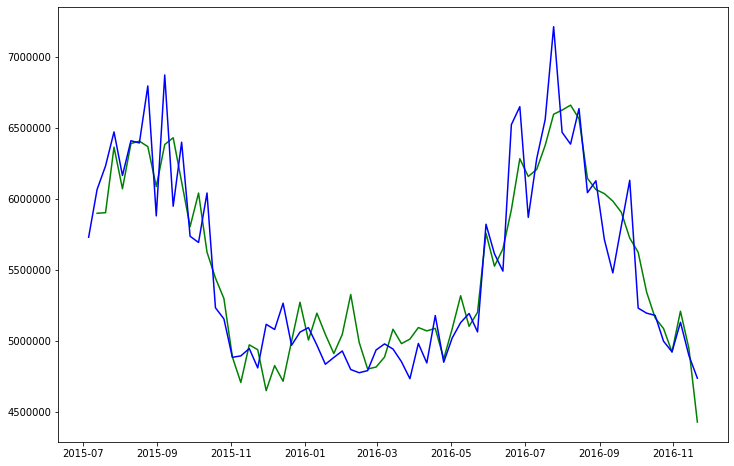

In [28]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat3[1:], c='g')
plt.plot(X_train.index, X_train['week_demand'].values, c='b')

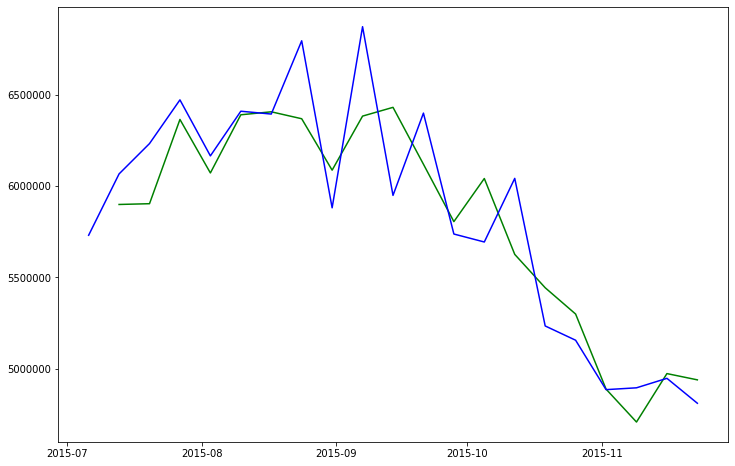

In [29]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat3[1:21], label='Prediction', c='g')
actual = X_train['week_demand'].values
plt.plot(X_train.index[:21], X_train['week_demand'].values[:21], label='Actual', c='b')

In [44]:
# Save the trained model
filename = 'SARIMAX_w_xexog_week.sav'
pickle.dump(model3, open(filename, 'wb'))

In [30]:
X_train.tail()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2016-10-24,4998192.0,13911737.0,81.35,80.34,79.15,68.47,78.09,83.80,15.424587
2016-10-31,4923159.0,13911737.0,86.26,77.12,74.70,70.78,73.61,76.89,15.409461
2016-11-07,5131645.0,13911737.0,93.09,93.61,78.05,73.52,76.26,83.08,15.450937
2016-11-14,4897298.0,13911737.0,87.53,83.86,70.18,64.58,73.51,76.66,15.404194
2016-11-21,4737510.0,13911737.0,79.03,76.49,63.73,59.76,61.00,61.10,15.371022


In [31]:
X_walk1.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2016-11-28,5025013.0,13911737.0,71.95,72.32,64.80,61.63,58.25,59.55,15.429939
2016-12-05,5116373.0,13911737.0,65.87,65.85,65.39,61.34,61.30,67.17,15.447956
2016-12-12,5088765.0,13911737.0,70.58,70.06,62.86,60.46,62.56,67.36,15.442546
2016-12-19,5136727.0,13911737.0,76.94,77.12,64.32,61.26,59.27,56.19,15.451927
2016-12-26,4936362.0,13996299.0,80.49,82.23,62.01,59.05,57.06,59.39,15.412139


In [32]:
predict_steps = 13
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[all_exog_columns].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

No handles with labels found to put in legend.


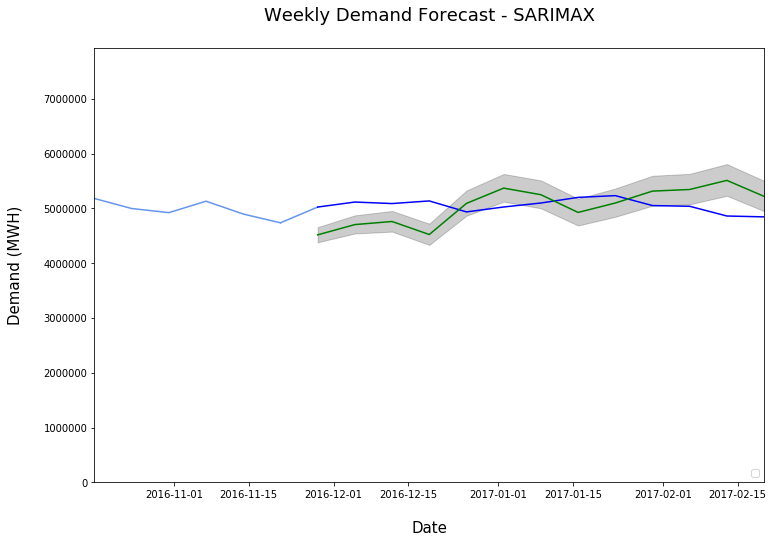

In [33]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Weekly Demand Forecast - SARIMAX\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['week_demand']), max(X_walk1['week_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], \
         X_train['week_demand'].values[-2*predict_steps:], c='cornflowerblue')
plt.plot([X_train.index[-1], X_walk1['week_demand'].index[0]], \
        [X_train['week_demand'].values[-1], X_walk1['week_demand'].values[0]], c='cornflowerblue')
plt.plot(X_walk1.index, X_walk1['week_demand'].values, c='b')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)
plt.savefig('weekly_demand_forecast_xwalk-sarima.png', Transparent=True)

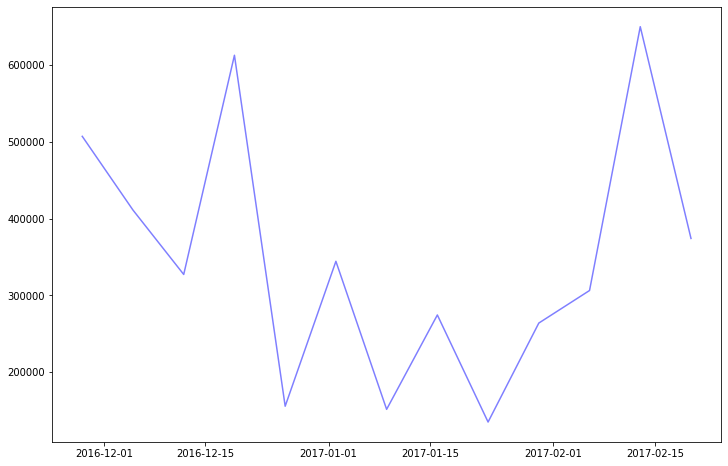

In [34]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['week_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
plt.plot(pred_times3, residuals3, c='b', alpha=0.5)
#plt.ylim(0, 10000)

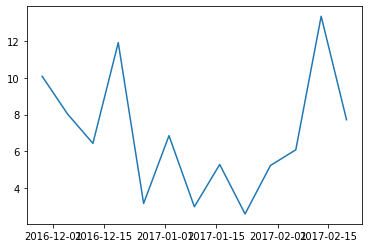

In [35]:
samp_len = min([len(X_walk1), len(pred_vals3)])
residuals = [abs(X_walk1['week_demand'].values[x] - pred_vals3.values[x]) for x in range(samp_len)]
percent_error = [residuals[x]/X_walk1['week_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3[:samp_len], percent_error)


(0, 20)

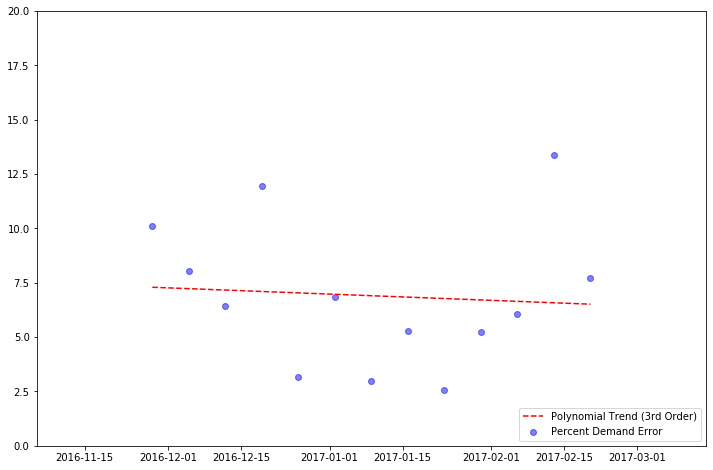

In [36]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['week_demand'].values[x] - pred_vals3.values[x])/ \
              X_walk1['week_demand'].values[x] * 100 for x in range(len(pred_vals3))]

timestamps = [int(x.timestamp()) for x in X_walk1.index[:predict_steps]]
z = np.polyfit(timestamps, residuals3, 1)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

plt.scatter(pred_times3, residuals3, c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_walk1.index[:predict_steps], trend,"r--", label='Polynomial Trend (3rd Order)')
plt.legend(loc='lower right')
plt.ylim(0, 20)

In [37]:
mape3 = np.mean(residuals3[:3])
print(mape3)

8.188308500664197


In [38]:
X_train = X_train.append(X_walk1)

In [39]:
X_train.tail()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2017-02-06,5039201.0,13996299.0,74.72,71.51,66.13,63.78,63.50,68.60,15.432758
2017-02-13,4861589.0,13996299.0,78.26,71.63,71.49,65.67,65.40,72.37,15.396876
2017-02-20,4845825.0,13996299.0,65.85,71.11,59.96,58.74,59.33,67.54,15.393628
2017-02-27,4802011.0,13996299.0,79.84,75.92,67.46,64.25,66.12,69.64,15.384545
2017-03-06,4789963.0,13996299.0,85.88,77.26,76.83,69.64,76.52,75.47,15.382033


In [40]:
X_walk2.head()

,week_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,log_demand
2017-03-13,4883098.0,13996299.0,87.63,82.75,82.00,76.10,79.31,86.14,15.401290
2017-03-20,4760186.0,13996299.0,69.31,68.61,68.26,63.19,69.51,75.17,15.375797
2017-03-27,4642255.0,13996299.0,81.57,76.89,78.77,73.80,79.32,78.54,15.350711
2017-04-03,4749068.0,13996299.0,82.82,74.70,77.68,70.63,80.49,82.38,15.373459
2017-04-10,4707345.0,13996299.0,76.13,71.62,70.49,65.22,68.69,77.65,15.364635


In [45]:
# Now choose the results that seem to work the best above and fit the model
best_order3 = (3, 0, 1)
best_seasonal_order3 = (2, 0, 0, 52)
model3 = SARIMAX(X_train['log_demand'], order=best_order3, seasonal_order=best_seasonal_order3,\
            exog=X_train[all_exog_columns])
res3 = model3.fit()

In [46]:
print(res3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          log_demand   No. Observations:                   88
Model:             SARIMAX(3, 0, 1)x(2, 0, [], 52)   Log Likelihood                 139.408
Date:                             Sun, 22 Mar 2020   AIC                           -258.817
Time:                                     21:12:31   BIC                           -234.043
Sample:                                 07-06-2015   HQIC                          -248.836
                                      - 03-06-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA_pop      1.066e-06    6.4e-09    166.602      0.000    1.05e-06    1.08e-06
la_high        0.0019      

In [47]:
predict_steps = 13
predict3_2 = res3.get_forecast(predict_steps, 
                exog=X_walk2[all_exog_columns].values[:predict_steps, :])
pred_ci3_2 = np.exp(predict3_2.conf_int(alpha=0.5))
pred_vals3_2 = np.exp(predict3_2.predicted_mean)

In [48]:
pred_vals3_2

2017-03-13    5.324430e+06
2017-03-20    4.870420e+06
2017-03-27    5.161261e+06
2017-04-03    5.367022e+06
2017-04-10    5.202675e+06
2017-04-17    5.428356e+06
2017-04-24    5.594125e+06
2017-05-01    6.167887e+06
2017-05-08    5.630856e+06
2017-05-15    6.225121e+06
2017-05-22    6.319674e+06
2017-05-29    6.147970e+06
2017-06-05    6.165026e+06
Freq: W-MON, dtype: float64

No handles with labels found to put in legend.


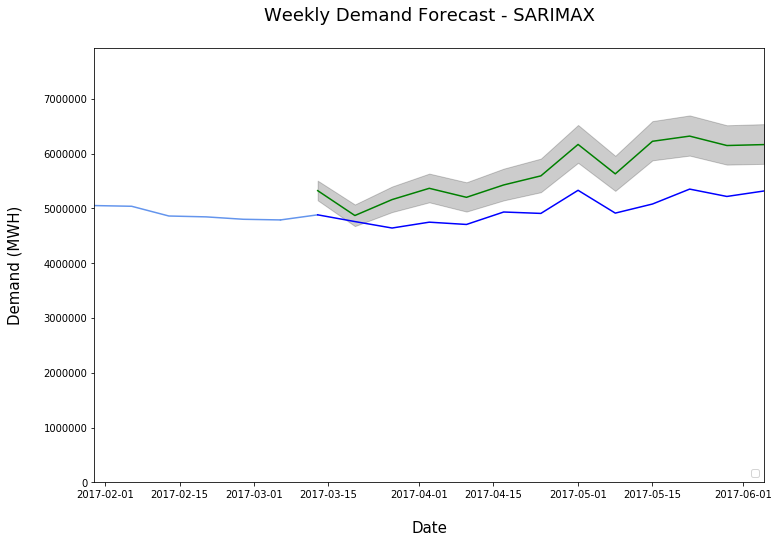

In [49]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Weekly Demand Forecast - SARIMAX\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3_2.iloc[:, 0].values
high_values = pred_ci3_2.iloc[:, 1].values
pred_times3_2 = pred_ci3_2.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3_2))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['week_demand']), max(X_walk2['week_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], \
         X_train['week_demand'].values[-2*predict_steps:], c='cornflowerblue')
plt.plot([X_train.index[-1], X_walk2['week_demand'].index[0]], \
        [X_train['week_demand'].values[-1], X_walk2['week_demand'].values[0]], c='cornflowerblue')
plt.plot(X_walk2.index, X_walk2['week_demand'].values, c='b')
plt.plot(pred_times3_2, pred_vals3_2.values, c='g')


plt.fill_between(pred_times3_2, low_values, high_values, color='k', alpha=0.2)
plt.savefig('weekly_demand_forecast_xwalk-sarima.png', Transparent=True)

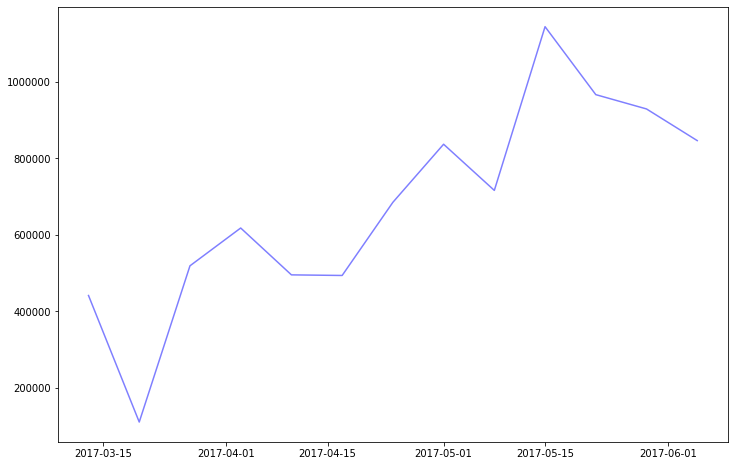

In [51]:
fig = plt.figure(figsize=[12, 8])
residuals3_2 = [abs(X_walk2['week_demand'].values[x] - pred_vals3_2.values[x]) for x in range(len(pred_vals3_2))]
plt.plot(pred_times3_2, residuals3_2, c='b', alpha=0.5)
#plt.ylim(0, 10000)

(0, 20)

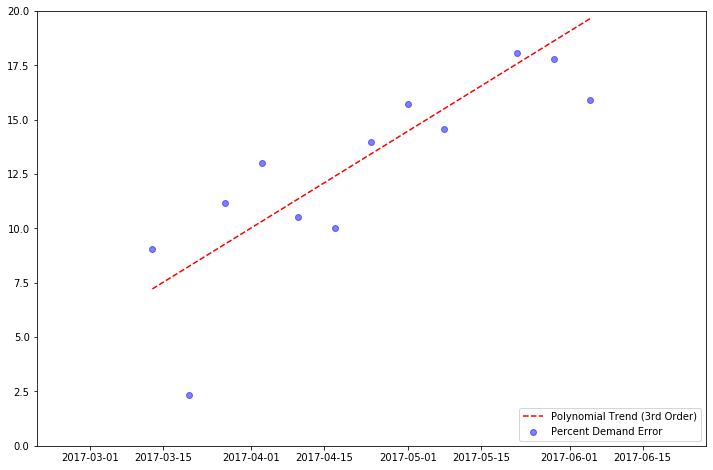

In [54]:
fig = plt.figure(figsize=[12, 8])
residuals3_2 = [abs(X_walk2['week_demand'].values[x] - pred_vals3_2.values[x])/ \
              X_walk2['week_demand'].values[x] * 100 for x in range(len(pred_vals3))]

timestamps = [int(x.timestamp()) for x in X_walk1.index[:predict_steps]]
z = np.polyfit(timestamps, residuals3_2, 1)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

plt.scatter(pred_times3_2, residuals3_2, c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_walk2.index[:predict_steps], trend,"r--", label='Polynomial Trend (3rd Order)')
plt.legend(loc='lower right')
plt.ylim(0, 20)

In [56]:
mape3_2 = np.mean(residuals3_2[:3])
print(mape3_2)

7.5112479895067


In [57]:
X_train = X_train.append(X_walk2)

In [58]:
# Now choose the results that seem to work the best above and fit the model
best_order3 = (3, 0, 1)
best_seasonal_order3 = (2, 0, 0, 52)
model3 = SARIMAX(X_train['log_demand'], order=best_order3, seasonal_order=best_seasonal_order3,\
            exog=X_train[all_exog_columns])
res3 = model3.fit()

In [59]:
print(res3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          log_demand   No. Observations:                  103
Model:             SARIMAX(3, 0, 1)x(2, 0, [], 52)   Log Likelihood                 156.692
Date:                             Sun, 22 Mar 2020   AIC                           -293.384
Time:                                     21:15:42   BIC                           -267.036
Sample:                                 07-06-2015   HQIC                          -282.712
                                      - 06-19-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA_pop      1.059e-06   6.61e-09    160.136      0.000    1.05e-06    1.07e-06
la_high        0.0045      

In [64]:
predict_steps = 13
predict3_3 = res3.get_forecast(predict_steps, 
                exog=X_walk3[all_exog_columns].values[:predict_steps, :])
pred_ci3_3 = np.exp(predict3_3.conf_int(alpha=0.5))
pred_vals3_3 = np.exp(predict3_3.predicted_mean)

No handles with labels found to put in legend.


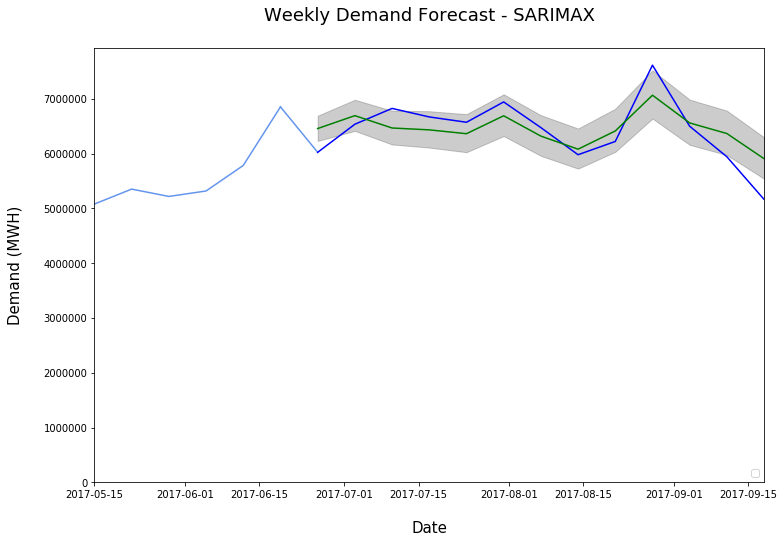

In [65]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Weekly Demand Forecast - SARIMAX\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3_3.iloc[:, 0].values
high_values = pred_ci3_3.iloc[:, 1].values
pred_times3_3 = pred_ci3_3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3_3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['week_demand']), max(X_walk2['week_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], \
         X_train['week_demand'].values[-2*predict_steps:], c='cornflowerblue')
plt.plot([X_train.index[-1], X_walk3['week_demand'].index[0]], \
        [X_train['week_demand'].values[-1], X_walk3['week_demand'].values[0]], c='cornflowerblue')
plt.plot(X_walk3.index, X_walk3['week_demand'].values, c='b')
plt.plot(pred_times3_3, pred_vals3_3.values, c='g')


plt.fill_between(pred_times3_3, low_values, high_values, color='k', alpha=0.2)
plt.savefig('weekly_demand_forecast_xwalk-sarima.png', Transparent=True)

(0, 20)

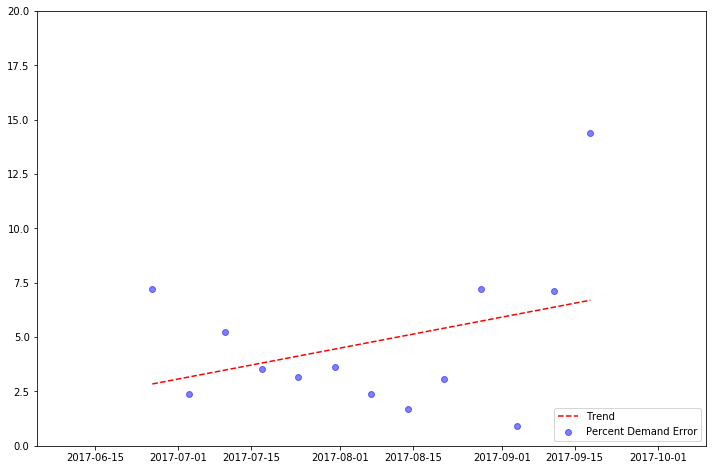

In [68]:
fig = plt.figure(figsize=[12, 8])
residuals3_3 = [abs(X_walk3['week_demand'].values[x] - pred_vals3_3.values[x])/ \
              X_walk3['week_demand'].values[x] * 100 for x in range(len(pred_vals3))]

timestamps = [int(x.timestamp()) for x in X_walk3.index[:predict_steps]]
z = np.polyfit(timestamps, residuals3_3, 1)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

plt.scatter(pred_times3_3, residuals3_3, c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_walk3.index[:predict_steps], trend,"r--", label='Trend')
plt.legend(loc='lower right')
plt.ylim(0, 20)

In [70]:
mape3_3 = np.mean(residuals3_3[:3])
print(mape3_3)

4.94470904012739
